Coordinate Regression on Sequence Data
------------------------------------------------------------

We have a video and for each frame we want to predict a value.

The labels as well as the video frames are noisy but the signal that is to be predicted can be assumed to be somewhat smooth.

Hence the idea to use a recurrent network with a smoothness loss.

In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Optional, List, NamedTuple, Any, Tuple
from torch import Tensor

## Data

Some cosine waves. Observations are created as 1d heatmaps encoding the current values as the locations of a gaussian.

Noise is added to the ground truth coordinates as well as the heatmaps.

In [2]:
import data
import util
import train

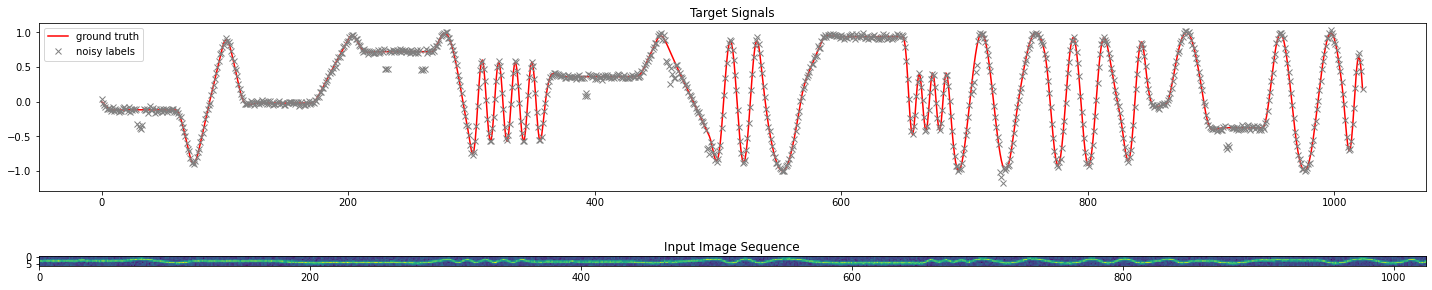

In [3]:
np.random.seed(123456+1)

gt_example, inputs_example, targets_example = data.make_synthetic_sequence(1024)

_ = data.plot_sequence(gt_example, inputs_example, targets_example)
plt.tight_layout()

## Model

In [4]:
device = 'cuda'

In [5]:
from models import Backbone, Out


class LSTM(nn.Module):

    def __init__(self, hidden_size = 8, num_layers = 1):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.backbone = Backbone()
        
        self.lstm = nn.LSTM(input_size=self.backbone.num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=False)
        
        self.fc = nn.Linear(hidden_size, 1)

    @property
    def device(self):
        return next(self.parameters()).device
        
    def create_initial_state(self, batchsize):
        h_0 = torch.zeros(
            self.num_layers, batchsize, self.hidden_size, device=self.device)
        c_0 = torch.zeros(
            self.num_layers, batchsize, self.hidden_size, device=self.device)
        return (h_0, c_0)
        
    def forward(self, visuals : Tensor, lstm_state : Tuple[Tensor,Tensor]):
        h_0, c_0 = lstm_state

        z = self.backbone(util.seq_as_batch(visuals))
        z = util.batch_as_seq_like(z, visuals)

        y, (h_out, c_out) = self.lstm(z, (h_0, c_0))
               
        y = self.fc(util.seq_as_batch(y))
        y = util.batch_as_seq_like(y, visuals)
        
        return Out(y,None), (h_out, c_out)

In [6]:
def test_lstm_model():
    model = LSTM().to(device)
    model.train()
    print ("Num Parameters: ", sum([p.numel() for p in model.parameters()]))
    seqs = util.split_and_stack(util.to_tensor(inputs_example, device=device), 64)[:,:,None,:]
    out, state = model(
        seqs,
        model.create_initial_state(seqs.size(1))
    )
    assert out.y.shape[0] == 64

    out, state = model(util.to_tensor(inputs_example, device=device)[:,None,None,:], model.create_initial_state(1))
    assert out.y.shape[0] == inputs_example.shape[0]

test_lstm_model()

Num Parameters:  3409


In [7]:
from models import SingleFrameRegression

# Note: Single frame model has at least as many parameters as recurrent model,
#       so given the infinite training data availability, it should not be limited by capacity nor
#       overfitting in comparison to the recurrent model.

def test_single_frame_regression():
    model = SingleFrameRegression().to(device)
    print ("Num Parameters: ", sum([p.numel() for p in model.parameters()]))
    out = model(util.to_tensor(inputs_example, device)[:,None,:])
    assert out.y.shape[0] == inputs_example.shape[0]

test_single_frame_regression()

Num Parameters:  4361


## Training

In [8]:
num_samples = 8 * 1024 * 1024
learning_rate = 0.01

In [9]:
testset = [
    (gt_example, inputs_example, targets_example),
]


def callmodel(model, x : Tensor):
    assert len(x.shape) == 2 # Length x Image Width
    if hasattr(model, 'create_initial_state'):
        # Sequencemodel
        inputs_tensor = util.to_tensor(x, model.device)[:,None, None,:]
        pred, _ = model(inputs_tensor, model.create_initial_state(1))
    else:
        # Single frame model
        inputs_tensor = util.to_tensor(x, model.device)[:,None,:] # Add channels dimension
        pred = model(inputs_tensor)
    mean = pred.y.detach().cpu().view(-1).numpy()
    std = np.sqrt(pred.r.detach().cpu().view(-1).numpy()) if pred.r is not None else None
    return mean, std


def evaluate(model):
    model.eval()
    
    def plot_samples_simple(samples):
        for pred in samples:
            plt.plot(pred, color='k', alpha=1./num_samples)
    
    def plot_samples_err_bounds(mean, std):
        plt.fill_between(np.arange(mean.shape[0]), mean-std, mean+std, color='b', alpha=0.25)
   
    num_samples = 10
    for gt, inputs, targets in testset:
        mean, std = callmodel(model, inputs)
        _ = plt.figure(figsize=(35,5))
        plt.plot(gt, color='r')
        plt.plot(mean, color='b', label='pred')
        if std is not None:
            plot_samples_err_bounds(mean, std)
        plt.legend()
        plt.show()

## Testing

In [10]:
sfmodel = SingleFrameRegression().to(device)
train.train_singleframe_model(sfmodel, num_samples, learning_rate)

Loss: 0.00476: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 16.14it/s]


In [11]:
lstm = LSTM().to(device)
train.train_sequence_model(lstm, num_samples, learning_rate, None, None)

Loss: 0.00486, Smoothness nan: 100%|████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.57it/s]


In [12]:
lstm_smooth_A = LSTM().to(device)
train.train_sequence_model(lstm_smooth_A, num_samples, learning_rate, 5., train.Smooth2ndDerivLoss().to(device))

Loss: 0.01055, Smoothness 0.00237: 100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.80it/s]


In [13]:
lstm_smooth_B = LSTM().to(device)
train.train_sequence_model(lstm_smooth_B, num_samples, learning_rate, 5., train.RobustSmooth2ndDerivLoss(eps=0.1).to(device))

Loss: 0.00604, Smoothness 0.00047: 100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.99it/s]


In [14]:
lstm_smooth_extreme = LSTM().to(device)
train.train_sequence_model(lstm_smooth_extreme, num_samples, learning_rate, 100., train.RobustSmooth2ndDerivLoss(eps=0.01).to(device))

Loss: 0.04932, Smoothness 0.00032: 100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.59it/s]


sfmodel


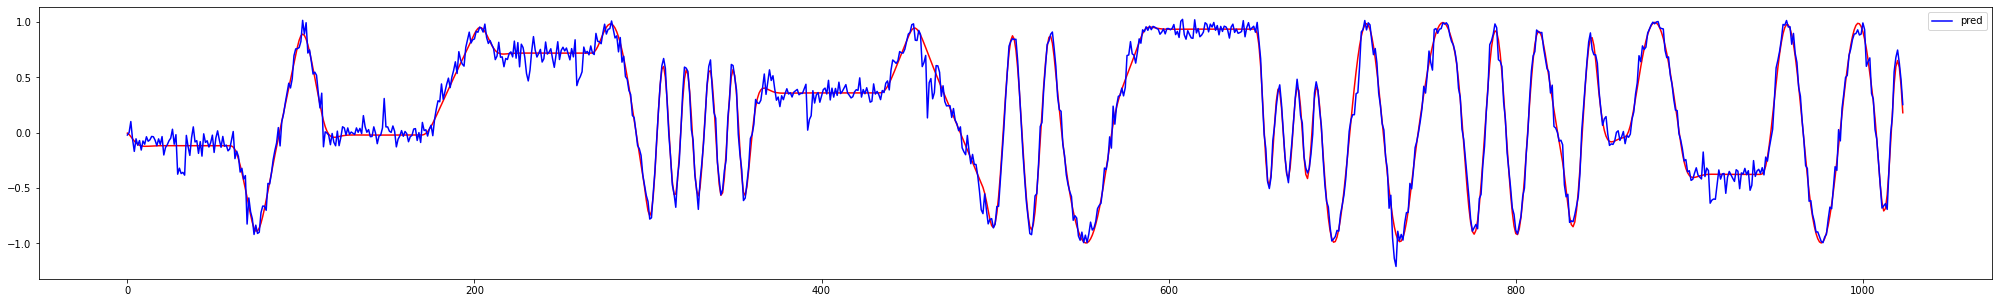

lstm model


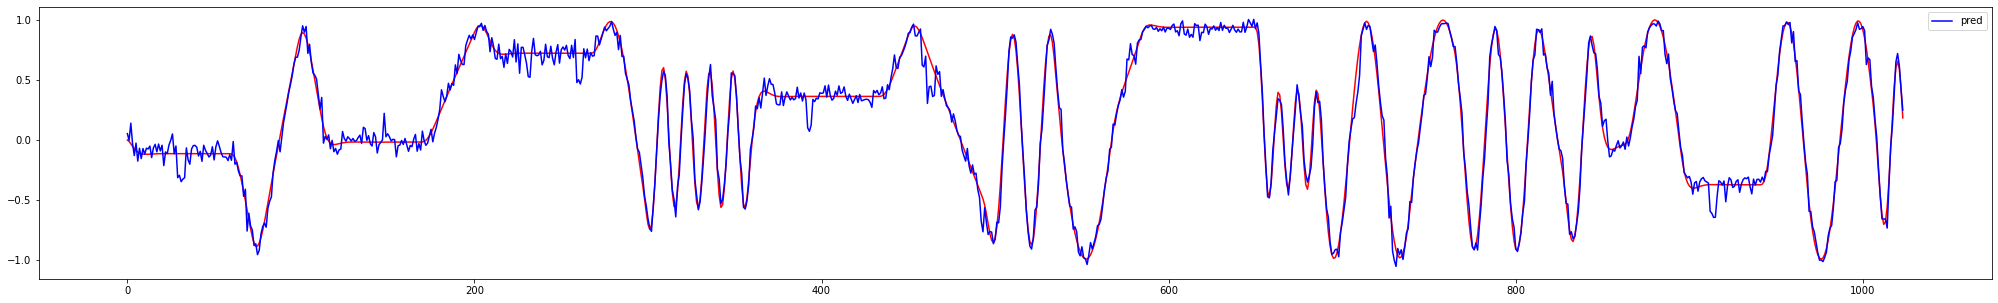

lstm_smooth_A


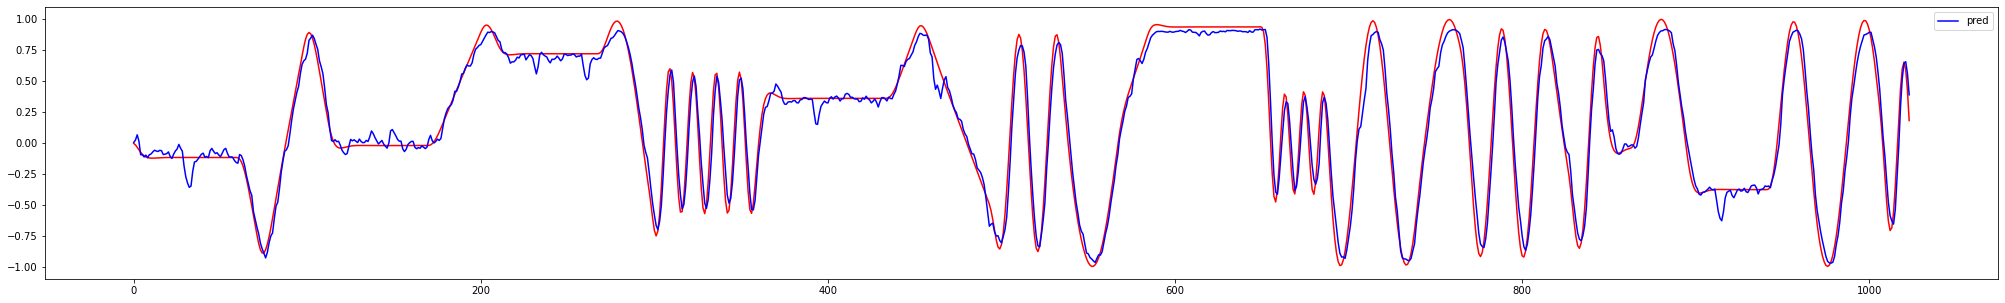

lstm_smooth_B


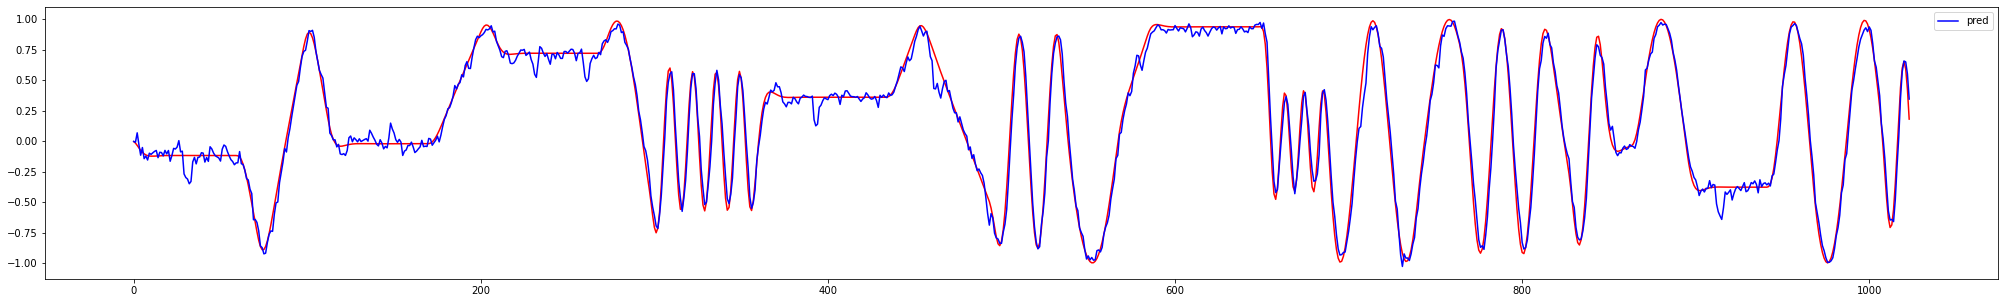

lstm_smooth_extreme


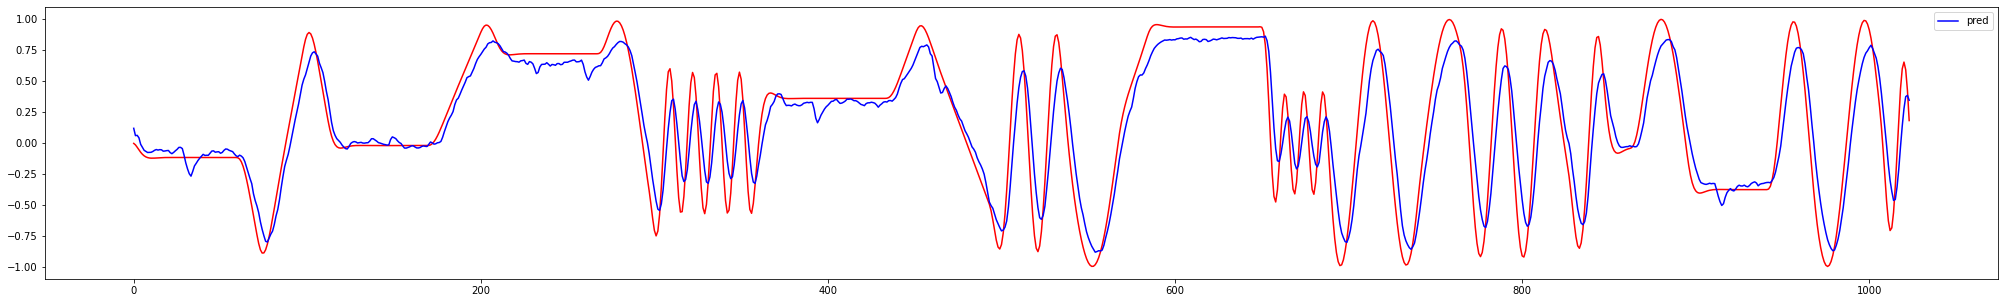

In [15]:
print('sfmodel'); evaluate(sfmodel)
print('lstm model'); evaluate(lstm)
print('lstm_smooth_A'); evaluate(lstm_smooth_A)
print('lstm_smooth_B'); evaluate(lstm_smooth_B)
print('lstm_smooth_extreme'); evaluate(lstm_smooth_extreme)

Export the model as ONNX
------------------------

In [16]:
import torch.onnx
import onnx
import onnxruntime as ort

In [17]:
net = lstm.to('cpu')

destination = '/tmp/lstm.onnx'

# Sequence length x Batches X Features X Image Width
x = torch.rand((1, 1, 1, 7))
h_0, c_0 = net.create_initial_state(1)

torch.onnx.export(
    net,  # model being run
    (x, (h_0, c_0)),  # model input (or a tuple for multiple inputs)
    destination,  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=12,  # the ONNX version to export the model to
    input_names = ['x', 'h0', 'c0'],
    output_names = ['y', "h_out", "c_out"],
    verbose=False)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
/opt/conda-env/ml/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:3220: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [18]:
# Quick test

ort_session = ort.InferenceSession(destination)

y, h, c = ort_session.run(None, {
    'x': x.numpy(),
    'h0': h_0.numpy(),
    'c0': c_0.numpy(),
})

print (y.shape, h.shape, c.shape)

(1, 1, 1) (1, 1, 8) (1, 1, 8)
